In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from subprocess import check_call

import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [4]:
df['age'].fillna(df['age'].mean(), inplace=True)
df.drop(columns='deck', axis=1, inplace=True) # deck 컬럼의 결측치 비율 = 688/891 = 0.7722 -> 삭제
df.drop(columns='embark_town', axis=1, inplace=True) # embarked와 겹치는 embark_town 열 삭제
df.drop(columns='alive', axis=1, inplace=True) # survived와 겹치는 alive 열 삭제

most_frequent = df['embarked'].value_counts(dropna=True).idxmax()
df['embarked'].fillna(most_frequent, inplace=True)

In [5]:
df.isnull().sum()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
class         0
who           0
adult_male    0
alone         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    891 non-null    int64   
 1   pclass      891 non-null    int64   
 2   sex         891 non-null    object  
 3   age         891 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        891 non-null    float64 
 7   embarked    891 non-null    object  
 8   class       891 non-null    category
 9   who         891 non-null    object  
 10  adult_male  891 non-null    bool    
 11  alone       891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(3)
memory usage: 65.5+ KB


In [7]:
new_df = pd.get_dummies(df, dtype=int)
new_df.head()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,True,False,0,1,0,0,1,0,0,1,0,1,0
1,1,1,38.0,1,0,71.2833,False,False,1,0,1,0,0,1,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,False,True,1,0,0,0,1,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,False,False,1,0,0,0,1,1,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,True,True,0,1,0,0,1,0,0,1,0,1,0


In [8]:
correlation_matrix = new_df.corr()
survived_correlation = correlation_matrix['survived'].sort_values(ascending=False)
print(abs(survived_correlation).sort_values(ascending=False))

survived        1.000000
adult_male      0.557080
who_man         0.557080
sex_male        0.543351
sex_female      0.543351
who_woman       0.506562
pclass          0.338481
class_Third     0.322308
class_First     0.285904
fare            0.257307
alone           0.203367
embarked_C      0.168240
embarked_S      0.149683
who_child       0.136107
class_Second    0.093349
parch           0.081629
age             0.069809
sibsp           0.035322
embarked_Q      0.003650
Name: survived, dtype: float64


In [9]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'alone'],
      dtype='object')

In [10]:
new_df = df[['survived', 'pclass', 'sex', 'fare', 'embarked', 'class', 'alone']]
new_df = pd.get_dummies(new_df, dtype=int)
new_df.head()

,survived,pclass,fare,alone,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third
0,0,3,7.2500,False,0,1,0,0,1,0,0,1
1,1,1,71.2833,False,1,0,1,0,0,1,0,0
2,1,3,7.9250,True,1,0,0,0,1,0,0,1
3,1,1,53.1000,False,1,0,0,0,1,1,0,0
4,0,3,8.0500,True,0,1,0,0,1,0,0,1


In [11]:
new_df.describe()

,survived,pclass,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,32.204208,0.352413,0.647587,0.188552,0.086420,0.725028,0.242424,0.206510,0.551066
std,0.486592,0.836071,49.693429,0.477990,0.477990,0.391372,0.281141,0.446751,0.428790,0.405028,0.497665
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Decision Tree 모델 적용

In [12]:
# titanic 데이터셋 로드
x = new_df.drop('survived', axis=1)
y = new_df['survived']

print(x.shape)
print(y.shape)

(891, 11)
(891,)


In [13]:
# gini로 결과가 나옴
tree_model_gini = DecisionTreeClassifier()
tree_model_gini.fit(x, y)

dot_data_decision = export_graphviz(
    tree_model_gini,
    out_file = './titanic_tree_model.dot',
    feature_names=x.columns.tolist(),
    class_names=y.map({1: 'Survived', 0: 'Dead'}).astype(str).unique(),
    rounded=True, # 사각형 끝을 둥글게
    filled=True # 사각형 안 색깔 채우기
)

# 예측한 모형 png로 바꿔서, 시각화 하기
check_call(['dot','-Tpng','titanic_tree_model.dot','-o','OutputFile_all_gini.png'])

0

In [14]:
# entropy로 결과가 나옴
tree_model_entropy = DecisionTreeClassifier(criterion="entropy")
tree_model_entropy.fit(x, y)

dot_data_decision = export_graphviz(
    tree_model_entropy,
    out_file = './titanic_tree_model.dot',
    feature_names=x.columns.tolist(),
    class_names=y.map({1: 'Survived', 0: 'Dead'}).astype(str).unique(),
    rounded=True,
    filled=True
)

# 예측한 모형 png로 바꿔서, 시각화 하기
check_call(['dot','-Tpng','titanic_tree_model.dot','-o','OutputFile_all_entropy.png'])

0

In [15]:
# [pruning] decision tree 모형 인스턴스 생성 및 하이퍼파라미터(depth) = 4
tree_model_max = DecisionTreeClassifier(criterion="entropy", max_depth=4)  # entropy로 결과가 나옴
tree_model_max.fit(x, y)

dot_data_decision = export_graphviz(
    tree_model_max,
    out_file = './titanic_tree_model.dot',
    feature_names=x.columns.tolist(),
    class_names=y.map({1: 'Survived', 0: 'Dead'}).astype(str).unique(),
    rounded=True,
    filled=True
)

# 예측한 모형 png로 바꿔서, 시각화 하기
check_call(['dot','-Tpng','titanic_tree_model.dot','-o','OutputFile_all_max_depth.png'])

0

In [16]:
# 1번 의사결정나무 - 지니계수 활용
confusion_matrix(y, tree_model_gini.predict(x))

array([[533,  16],
       [ 61, 281]])

In [17]:
# 2번 의사결정나무 - entropy 활용
confusion_matrix(y, tree_model_entropy.predict(x))

array([[533,  16],
       [ 61, 281]])

In [18]:
# 3번 의사결정나무 - 가지치기 작업
confusion_matrix(y, tree_model_max.predict(x))

array([[525,  24],
       [139, 203]])

# Test/Train spilit

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=1)
print(x_train.shape, x_test.shape)

(668, 11) (223, 11)


In [20]:
# train dataset
tree_model_train = DecisionTreeClassifier(criterion="entropy")
tree_model_train.fit(x_train,y_train)

# test dataset predict
confusion_matrix(y_test, tree_model_train.predict(x_test))

array([[123,  14],
       [ 23,  63]])

In [21]:
# 오분류
print(37/223)

0.16591928251121077


In [22]:
# normal tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)
y_train_pred = tree_model.predict(x_train)
y_test_pred = tree_model.predict(x_test)

In [23]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9221556886227545
Test score 0.8340807174887892


### 1. Pre prunning

In [24]:
params = {'max_depth': [2,4,6,8,10],
         'min_samples_split': [2,3],
         'min_samples_leaf': [2,3]}

tree_model = DecisionTreeClassifier()
gscv = GridSearchCV(estimator=tree_model,param_grid=params)
gscv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3]})

In [25]:
model = gscv.best_estimator_
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')

Train score 0.8143712574850299
Test score 0.7982062780269058


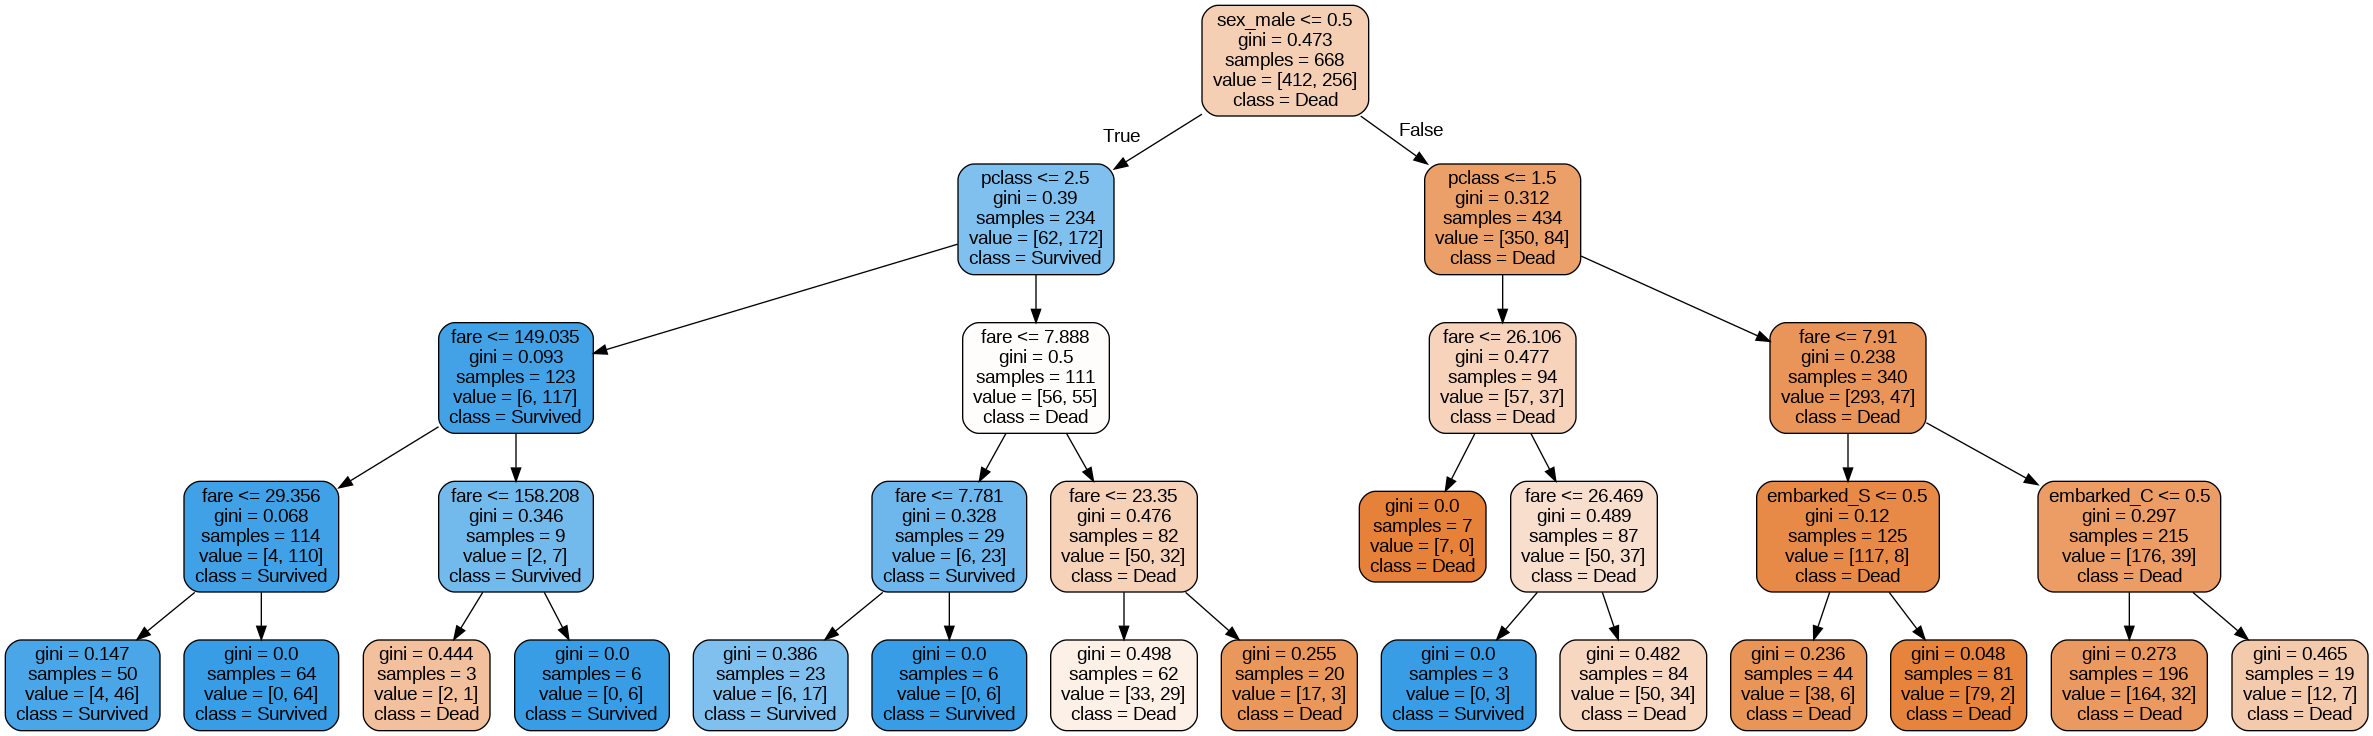

In [26]:
dot_data_decision = export_graphviz(
    model,
    out_file='./titanic_tree_model.dot',
    feature_names=x.columns.tolist(),
    class_names=y.map({1: 'Survived', 0: 'Dead'}).astype(str).unique(),
    rounded=True,
    filled=True
)

check_call(['dot', '-Tpng', 'titanic_tree_model.dot', '-o', 'OutputFile_all_pre_pruning.png'])

Image(filename='OutputFile_all_pre_pruning.png')

### 2. Post pruning

In [27]:
post_pruning = tree_model.cost_complexity_pruning_path(x_train, y_train)
alphas, impurities = post_pruning.ccp_alphas, post_pruning.impurities

In [28]:
dtcs = []
for ccp_alpha in alphas:
    dtc = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dtc.fit(x_train, y_train)
    dtcs.append(dtc)

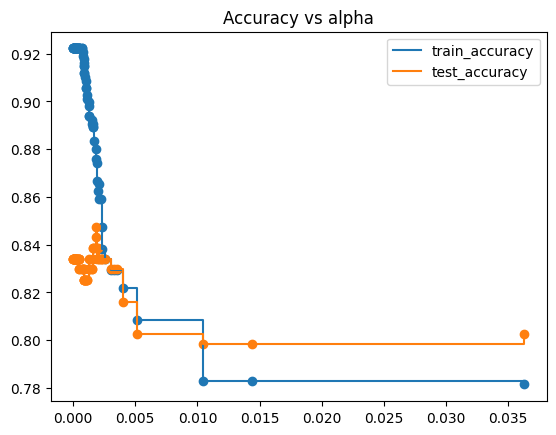

In [29]:
dtcs = dtcs[:-1]
alphas = alphas[:-1]
train_acc = []
test_acc = []
for d in dtcs:
    y_train_pred = d.predict(x_train)
    y_test_pred = d.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(alphas,train_acc)
plt.scatter(alphas,test_acc)
plt.plot(alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [30]:
dtc_ = DecisionTreeClassifier(ccp_alpha=0.010)
dtc_.fit(x_train,y_train)
y_train_pred = dtc_.predict(x_train)
y_test_pred = dtc_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.8083832335329342
Test score 0.8026905829596412


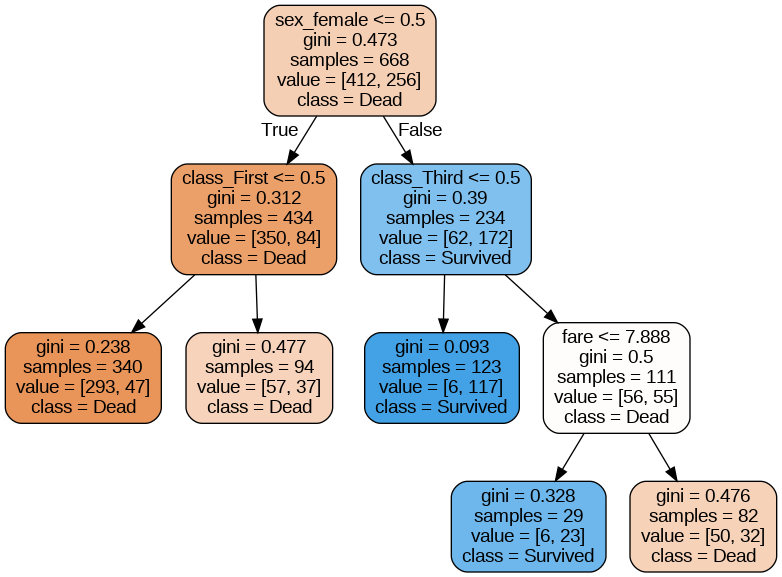

In [31]:
dot_data_decision = export_graphviz(
    dtc_,
    out_file='./titanic_tree_model.dot',
    feature_names=x.columns.tolist(),
    class_names=y.map({1: 'Survived', 0: 'Dead'}).astype(str).unique(),
    rounded=True,
    filled=True
)

check_call(['dot', '-Tpng', 'titanic_tree_model.dot', '-o', 'OutputFile_all_post_pruning.png'])

Image(filename='OutputFile_all_post_pruning.png')

In [33]:
# pruning 후 decision tree의 크기가 크게 줄어들었으며, post pruning이 pre pruning보다 효율적